In [1]:
import pandas as pd
import numpy as np
from datetime import date, timedelta
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
faturamento_df = pd.read_csv("data/faturamento_lojas_atuais.csv")
lojas_df = pd.read_csv("data/lojas_atuais.csv")

### Tratamento dos dados

In [3]:
faturamento_df["datetime"] = pd.to_datetime(faturamento_df.ano*100 + faturamento_df.mes, format='%Y%m')
fat_df = faturamento_df.groupby(["cod_loja", "datetime"] , as_index=False).sum()
fat_df.drop(["ano", "mes", "qtde"], axis=1, inplace=True)

df = fat_df.merge(lojas_df, left_on="cod_loja", right_on="cod_loja")
df["quarter"] = df["datetime"].dt.quarter
df["ano"] = df["datetime"].dt.year
df["mes"] = df["datetime"].dt.month
df["feature_03"] = df["feature_03"].apply(lambda x: 1 if x else 0)

In [4]:
print(df.shape)
df.head()

(73644, 26)


,cod_loja,datetime,receita,cod_ap,cod_municipio,feature_01,feature_02,feature_03,feature_04,feature_05,...,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,quarter,ano,mes
0,1,2016-01-01,441833.37,4125506005002,4125506,NaN,FEATURE_02_VALUE_04,1,21.76,FEATURE_05_VALUE_04,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2016,1
1,1,2016-02-01,395340.22,4125506005002,4125506,NaN,FEATURE_02_VALUE_04,1,21.76,FEATURE_05_VALUE_04,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2016,2
2,1,2016-03-01,587810.18,4125506005002,4125506,NaN,FEATURE_02_VALUE_04,1,21.76,FEATURE_05_VALUE_04,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2016,3
3,1,2016-04-01,534618.84,4125506005002,4125506,NaN,FEATURE_02_VALUE_04,1,21.76,FEATURE_05_VALUE_04,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,2016,4
4,1,2016-05-01,595477.92,4125506005002,4125506,NaN,FEATURE_02_VALUE_04,1,21.76,FEATURE_05_VALUE_04,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,2016,5


In [5]:
def categoriza_lojas(row):
    if row["receita"] <= 75000:
        return 0
    elif row["receita"] <= 2e5:
        return 10
    elif row["receita"] <= 4e5:
        return 20
    elif row["receita"] <= 6e5:
        return 30
    else:
        return 40
    
def obtem_categoria(cod_loja):
    return categorias_df[categorias_df["cod_loja"] == cod_loja]["categoria_loja"].values[0]


categorias_df = df.groupby(["cod_loja"], as_index=False).mean()[["cod_loja", "receita"]]
categorias_df["categoria_loja"] = categorias_df.apply(categoriza_lojas, axis=1)

df["categoria_loja"] = df["cod_loja"].apply(obtem_categoria)

In [80]:
def get_mean_of_my_category(row):
    my_category_and_month = df[(df["categoria_loja"] == row["categoria_loja"]) & (df["mes"] == row["mes"])]
    
    return np.mean(my_category_and_month["receita"].values)

df["receita_minha_categoria"] = df.apply(get_mean_of_my_category, axis=1)

In [ ]:
feriados_df = pd.read_csv("data/feriados.csv")
df = df.merge(feriados_df, left_on=['cod_loja', 'mes'], right_on=['cod_loja', 'mes'])
df.drop(columns=['Unnamed: 0'], inplace=True)

In [6]:
df.head()

,cod_loja,datetime,receita,cod_ap,cod_municipio,feature_01,feature_02,feature_03,feature_04,feature_05,...,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,quarter,ano,mes,categoria_loja
0,1,2016-01-01,441833.37,4125506005002,4125506,NaN,FEATURE_02_VALUE_04,1,21.76,FEATURE_05_VALUE_04,...,NaN,NaN,NaN,NaN,NaN,NaN,1,2016,1,40
1,1,2016-02-01,395340.22,4125506005002,4125506,NaN,FEATURE_02_VALUE_04,1,21.76,FEATURE_05_VALUE_04,...,NaN,NaN,NaN,NaN,NaN,NaN,1,2016,2,40
2,1,2016-03-01,587810.18,4125506005002,4125506,NaN,FEATURE_02_VALUE_04,1,21.76,FEATURE_05_VALUE_04,...,NaN,NaN,NaN,NaN,NaN,NaN,1,2016,3,40
3,1,2016-04-01,534618.84,4125506005002,4125506,NaN,FEATURE_02_VALUE_04,1,21.76,FEATURE_05_VALUE_04,...,NaN,NaN,NaN,NaN,NaN,NaN,2,2016,4,40
4,1,2016-05-01,595477.92,4125506005002,4125506,NaN,FEATURE_02_VALUE_04,1,21.76,FEATURE_05_VALUE_04,...,NaN,NaN,NaN,NaN,NaN,NaN,2,2016,5,40


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73644 entries, 0 to 73643
Data columns (total 27 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   cod_loja        73644 non-null  int64         
 1   datetime        73644 non-null  datetime64[ns]
 2   receita         73644 non-null  float64       
 3   cod_ap          73644 non-null  int64         
 4   cod_municipio   73644 non-null  int64         
 5   feature_01      26972 non-null  object        
 6   feature_02      73644 non-null  object        
 7   feature_03      73644 non-null  int64         
 8   feature_04      73644 non-null  float64       
 9   feature_05      73644 non-null  object        
 10  feature_06      73644 non-null  int64         
 11  feature_07      73644 non-null  float64       
 12  feature_08      73644 non-null  float64       
 13  feature_09      73644 non-null  float64       
 14  feature_10      73644 non-null  float64       
 15  fe

In [8]:
has_na_cols = list()
for col in df.columns:
    if df[col].isnull().values.any():
        has_na_cols.append(col)
has_na_cols

['feature_01',
 'feature_11',
 'feature_12',
 'feature_13',
 'feature_14',
 'feature_15',
 'feature_16',
 'feature_17',
 'feature_18']

In [9]:
for na_col in has_na_cols:
    if df[na_col].dtype == object:
        print(df[na_col].mode()[0])
        df[na_col].fillna(df[na_col].mode()[0], inplace=True)
    else:
        df[na_col].fillna(df[na_col].median(), inplace=True)

FEATURE_01_VALUE_10
FEATURE_11_VALUE_02
FEATURE_12_VALUE_01


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73644 entries, 0 to 73643
Data columns (total 27 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   cod_loja        73644 non-null  int64         
 1   datetime        73644 non-null  datetime64[ns]
 2   receita         73644 non-null  float64       
 3   cod_ap          73644 non-null  int64         
 4   cod_municipio   73644 non-null  int64         
 5   feature_01      73644 non-null  object        
 6   feature_02      73644 non-null  object        
 7   feature_03      73644 non-null  int64         
 8   feature_04      73644 non-null  float64       
 9   feature_05      73644 non-null  object        
 10  feature_06      73644 non-null  int64         
 11  feature_07      73644 non-null  float64       
 12  feature_08      73644 non-null  float64       
 13  feature_09      73644 non-null  float64       
 14  feature_10      73644 non-null  float64       
 15  fe

## Adicionar a receita do ultimo trimestre

In [11]:
df.head()

,cod_loja,datetime,receita,cod_ap,cod_municipio,feature_01,feature_02,feature_03,feature_04,feature_05,...,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,quarter,ano,mes,categoria_loja
0,1,2016-01-01,441833.37,4125506005002,4125506,FEATURE_01_VALUE_10,FEATURE_02_VALUE_04,1,21.76,FEATURE_05_VALUE_04,...,100.0,86.9,100.0,100.0,91.1,90.5,1,2016,1,40
1,1,2016-02-01,395340.22,4125506005002,4125506,FEATURE_01_VALUE_10,FEATURE_02_VALUE_04,1,21.76,FEATURE_05_VALUE_04,...,100.0,86.9,100.0,100.0,91.1,90.5,1,2016,2,40
2,1,2016-03-01,587810.18,4125506005002,4125506,FEATURE_01_VALUE_10,FEATURE_02_VALUE_04,1,21.76,FEATURE_05_VALUE_04,...,100.0,86.9,100.0,100.0,91.1,90.5,1,2016,3,40
3,1,2016-04-01,534618.84,4125506005002,4125506,FEATURE_01_VALUE_10,FEATURE_02_VALUE_04,1,21.76,FEATURE_05_VALUE_04,...,100.0,86.9,100.0,100.0,91.1,90.5,2,2016,4,40
4,1,2016-05-01,595477.92,4125506005002,4125506,FEATURE_01_VALUE_10,FEATURE_02_VALUE_04,1,21.76,FEATURE_05_VALUE_04,...,100.0,86.9,100.0,100.0,91.1,90.5,2,2016,5,40


In [12]:
df.shape

(73644, 27)

In [13]:
receita_ultimo_trimestre = []

for index, row in df.iterrows():
    if row["ano"] == 2016 and row["quarter"] == 1:
        receita_ultimo_trimestre.append([index, 0,0,0,0])
    # Há semestre anterior
    else:
        #ultimo trimestre do ano passado
        quarter = row["quarter"] - 1
        ano = row["ano"]
        
        if quarter == 0:
            ano = row["ano"]-1
            quarter = 4
            
        last_quarter_df = df[(df["cod_loja"] == row["cod_loja"]) & (df["quarter"] == quarter) & (df["ano"] == ano)] \
                          .sort_values("datetime")[["datetime", "receita"]]
        receita = last_quarter_df["receita"].values
        if len(receita) == 3:
            receita_ultimo_trimestre.append([index, receita[0], receita[1], receita[2], np.mean(receita)])
        else:
            ## rever
            receita_ultimo_trimestre.append([index, 0, 0, 0, 0])
            
    
receita_ultimo_trimestre_df = pd.DataFrame(receita_ultimo_trimestre, columns=["index", "receita_trim1", "receita_trim2", "receita_trim3", "receita_media"]).set_index("index")
receita_ultimo_trimestre_df.head()
df = df.merge(receita_ultimo_trimestre_df, left_index=True, right_index=True)

In [14]:
df.shape

(73644, 31)

In [15]:
## receita no mesmo mês do ana passado
receita_ano_passado = []

for index, row in df.iterrows():
    year_ago = row["datetime"].replace(year=row["ano"]-1)
    
    year_agora_df = df[(df["cod_loja"] == row["cod_loja"]) & (df["datetime"] == year_ago)]
    
    if year_agora_df.shape[0] == 1:
        receita_ano_passado.append([index, year_agora_df["receita"].values[0]])
    else:
        receita_ano_passado.append([index, 0])
        
receita_ultimo_ano_df = pd.DataFrame(receita_ano_passado, columns=["index", "receita_ano_passado"]).set_index("index")
receita_ultimo_ano_df.head()
df = df.merge(receita_ultimo_ano_df, left_index=True, right_index=True)
df.shape

(73644, 32)

# Rodar apartir daqui!!

In [168]:
df = pd.read_csv("data/faturamento_consolidade_com_feriado_e_receita_da_categoria.csv", parse_dates=["datetime"])
df.shape

(73644, 34)

In [169]:
df.head()

,cod_loja,datetime,receita,cod_ap,cod_municipio,feature_01,feature_02,feature_03,feature_04,feature_05,...,ano,mes,categoria_loja,receita_trim1,receita_trim2,receita_trim3,receita_media,receita_ano_passado,cnt_feriados,receita_minha_categoria
0,1,2016-01-01,441833.37,4125506005002,4125506,FEATURE_01_VALUE_10,FEATURE_02_VALUE_04,1,21.76,FEATURE_05_VALUE_04,...,2016,1,40,0.0,0.00,0.0,0.000000,0.00,1.0,552910.464333
1,1,2017-01-01,404108.77,4125506005002,4125506,FEATURE_01_VALUE_10,FEATURE_02_VALUE_04,1,21.76,FEATURE_05_VALUE_04,...,2017,1,40,611797.3,876921.63,1257613.0,915443.976667,441833.37,1.0,552910.464333
2,1,2016-02-01,395340.22,4125506005002,4125506,FEATURE_01_VALUE_10,FEATURE_02_VALUE_04,1,21.76,FEATURE_05_VALUE_04,...,2016,2,40,0.0,0.00,0.0,0.000000,0.00,0.0,435209.493667
3,1,2017-02-01,483610.18,4125506005002,4125506,FEATURE_01_VALUE_10,FEATURE_02_VALUE_04,1,21.76,FEATURE_05_VALUE_04,...,2017,2,40,611797.3,876921.63,1257613.0,915443.976667,395340.22,0.0,435209.493667
4,1,2016-03-01,587810.18,4125506005002,4125506,FEATURE_01_VALUE_10,FEATURE_02_VALUE_04,1,21.76,FEATURE_05_VALUE_04,...,2016,3,40,0.0,0.00,0.0,0.000000,0.00,0.0,520654.621333


In [170]:
df.columns

Index(['cod_loja', 'datetime', 'receita', 'cod_ap', 'cod_municipio',
       'feature_01', 'feature_02', 'feature_03', 'feature_04', 'feature_05',
       'feature_06', 'feature_07', 'feature_08', 'feature_09', 'feature_10',
       'feature_11', 'feature_12', 'feature_13', 'feature_14', 'feature_15',
       'feature_16', 'feature_17', 'feature_18', 'quarter', 'ano', 'mes',
       'categoria_loja', 'receita_trim1', 'receita_trim2', 'receita_trim3',
       'receita_media', 'receita_ano_passado', 'cnt_feriados',
       'receita_minha_categoria'],
      dtype='object')

In [171]:
dummies_df = pd.get_dummies(df, columns=["feature_05"])
dummies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73644 entries, 0 to 73643
Data columns (total 41 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   cod_loja                        73644 non-null  int64         
 1   datetime                        73644 non-null  datetime64[ns]
 2   receita                         73644 non-null  float64       
 3   cod_ap                          73644 non-null  int64         
 4   cod_municipio                   73644 non-null  int64         
 5   feature_01                      73644 non-null  object        
 6   feature_02                      73644 non-null  object        
 7   feature_03                      73644 non-null  int64         
 8   feature_04                      73644 non-null  float64       
 9   feature_06                      73644 non-null  int64         
 10  feature_07                      73644 non-null  float64       
 11  fe

In [198]:
train_df = dummies_df[~dummies_df["datetime"].isin([date(2017,10,1), date(2017,11,1), date(2017,12,1)])]
test_df =  dummies_df[dummies_df["datetime"].isin([date(2017,10,1), date(2017,11,1), date(2017,12,1)])]

In [199]:
str_cols = []        
str_cols.append("feature_01")
str_cols.append("feature_02")
str_cols.append("feature_11")
str_cols.append("feature_12")
str_cols.append("datetime")
str_cols.append("receita")
str_cols.append("receita_trim1")
str_cols.append("receita_trim2")
str_cols.append("receita_trim3")
str_cols.append("receita_minha_categoria")
#str_cols.append('categoria_loja')
#str_cols.append('receita_media')
str_cols.append('receita_ano_passado')

X_train = train_df.drop(str_cols, axis=1, errors="ignore")
y_train = train_df["receita"]

X_test = test_df.drop(str_cols, axis=1, errors="ignore")
y_test = test_df["receita"]

In [200]:
X_test.columns

Index(['cod_loja', 'cod_ap', 'cod_municipio', 'feature_03', 'feature_04',
       'feature_06', 'feature_07', 'feature_08', 'feature_09', 'feature_10',
       'feature_13', 'feature_14', 'feature_15', 'feature_16', 'feature_17',
       'feature_18', 'quarter', 'ano', 'mes', 'categoria_loja',
       'receita_media', 'cnt_feriados', 'feature_05_FEATURE_05_VALUE_01',
       'feature_05_FEATURE_05_VALUE_02', 'feature_05_FEATURE_05_VALUE_03',
       'feature_05_FEATURE_05_VALUE_04', 'feature_05_FEATURE_05_VALUE_05',
       'feature_05_FEATURE_05_VALUE_06', 'feature_05_FEATURE_05_VALUE_07',
       'feature_05_FEATURE_05_VALUE_08'],
      dtype='object')

In [201]:
X_train.columns

Index(['cod_loja', 'cod_ap', 'cod_municipio', 'feature_03', 'feature_04',
       'feature_06', 'feature_07', 'feature_08', 'feature_09', 'feature_10',
       'feature_13', 'feature_14', 'feature_15', 'feature_16', 'feature_17',
       'feature_18', 'quarter', 'ano', 'mes', 'categoria_loja',
       'receita_media', 'cnt_feriados', 'feature_05_FEATURE_05_VALUE_01',
       'feature_05_FEATURE_05_VALUE_02', 'feature_05_FEATURE_05_VALUE_03',
       'feature_05_FEATURE_05_VALUE_04', 'feature_05_FEATURE_05_VALUE_05',
       'feature_05_FEATURE_05_VALUE_06', 'feature_05_FEATURE_05_VALUE_07',
       'feature_05_FEATURE_05_VALUE_08'],
      dtype='object')

### Treinar o modelo

In [202]:
rf = RandomForestRegressor(n_estimators=100, n_jobs=2, verbose=2)
rf.fit(X_train, y_train)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 100building tree 2 of 100

building tree 3 of 100
building tree 4 of 100
building tree 5 of 100building tree 6 of 100

building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100


[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:   14.0s


building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100building tree 58 of 100

building tree 59 of 100building tree 60 of 100

building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82

[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:   36.3s finished


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=2, oob_score=False,
                      random_state=None, verbose=2, warm_start=False)

In [203]:
y_test_pred = rf.predict(X_test)
y_train_pred = rf.predict(X_train) 
np.sqrt(mean_squared_error(y_train, y_train_pred)), np.sqrt(mean_squared_error(y_test, y_test_pred))

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.8s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    1.7s finished


(7775.088707097139, 29664.27263146742)

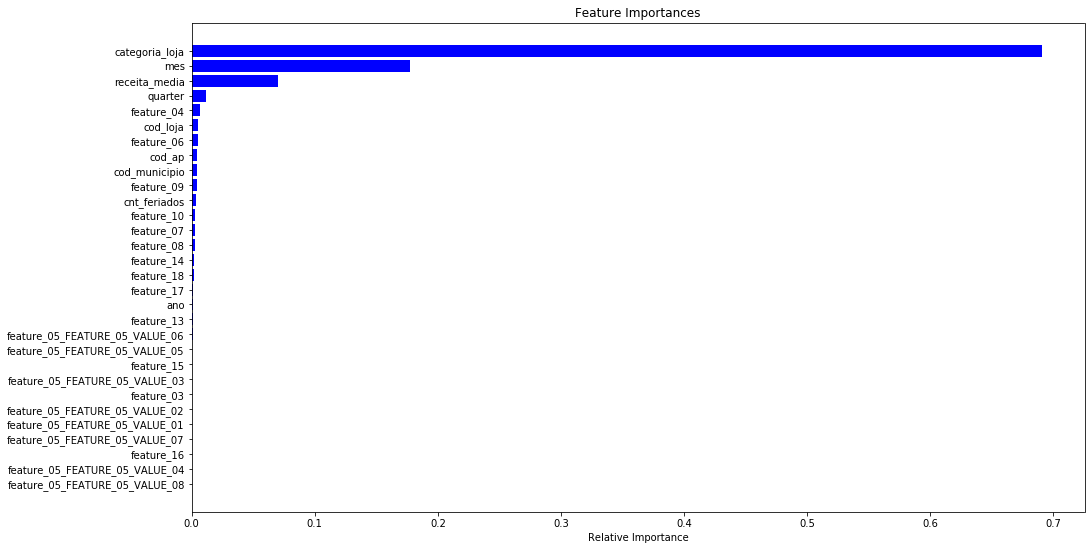

In [204]:
def print_feature_importances(model, cols):
    features = cols
    importances = model.feature_importances_
    indices = np.argsort(importances)
    plt.figure(figsize=(16,9))
    plt.title('Feature Importances')
    plt.barh(range(len(indices)), importances[indices], color='b', align='center')
    plt.yticks(range(len(indices)), [features[i] for i in indices])
    plt.xlabel('Relative Importance');
    
print_feature_importances(rf, X_train.columns)  

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished


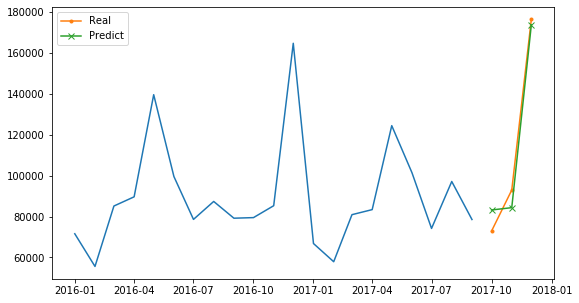

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished


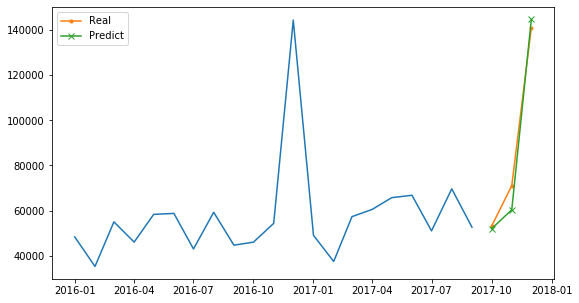

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished


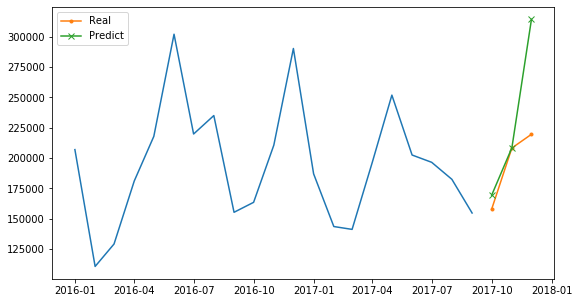

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished


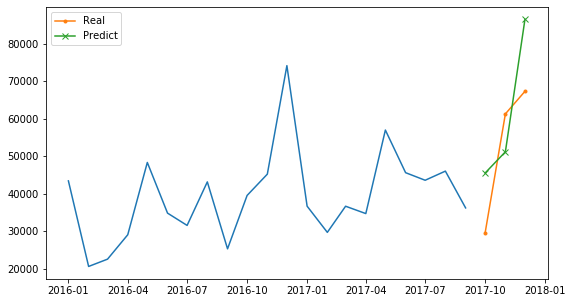

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished


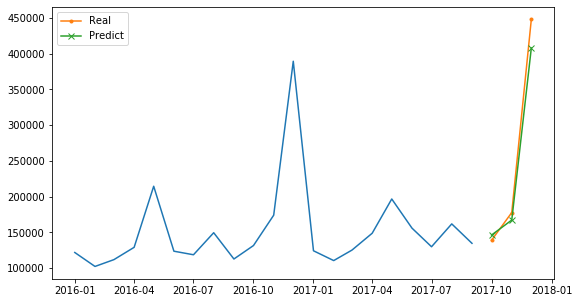

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished


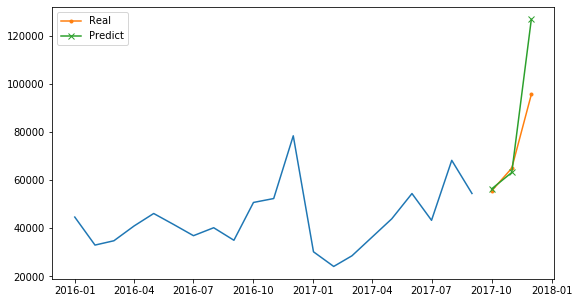

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished


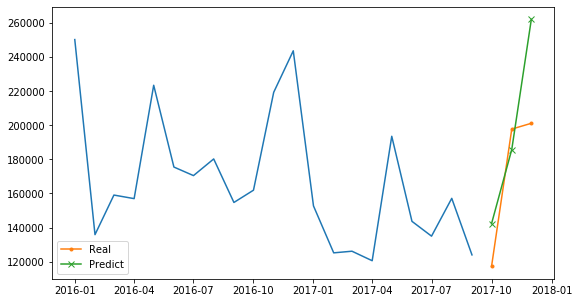

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished


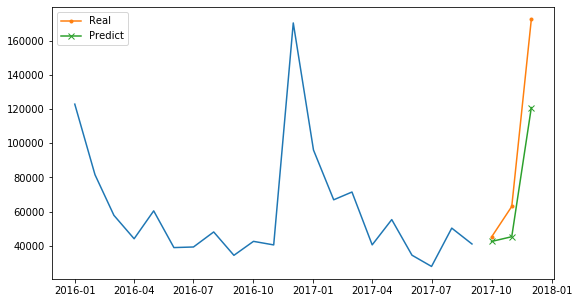

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished


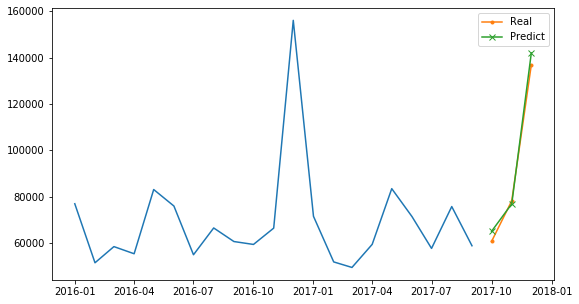

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished


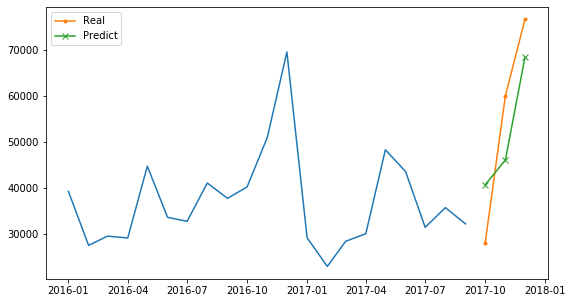

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished


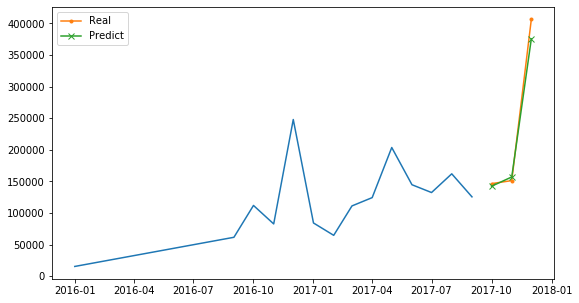

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished


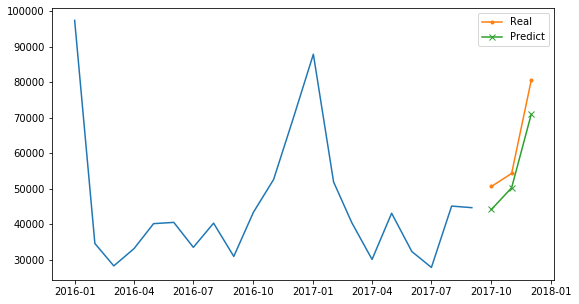

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished


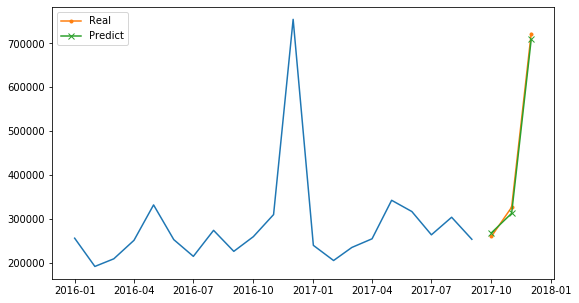

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished


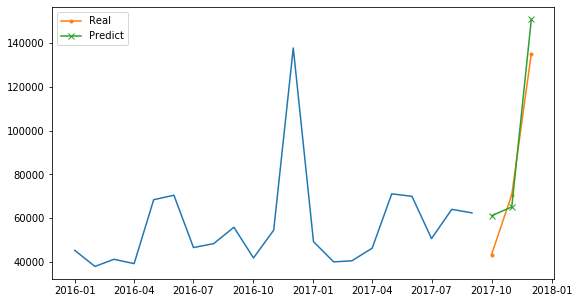

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished


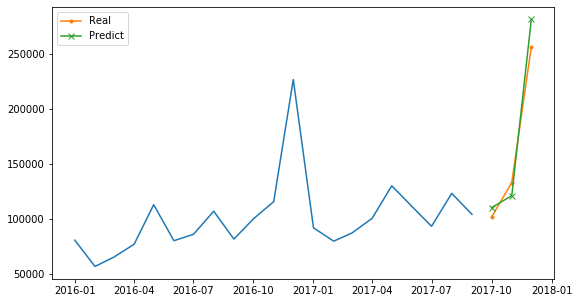

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished


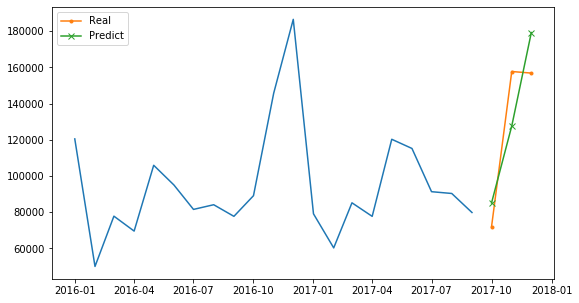

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished


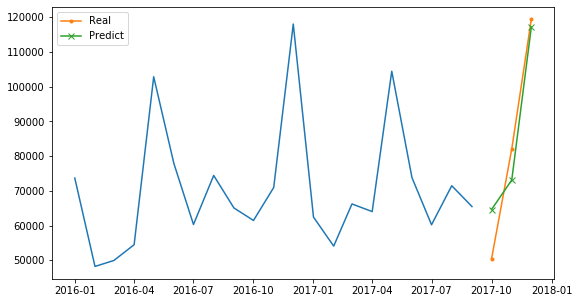

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished


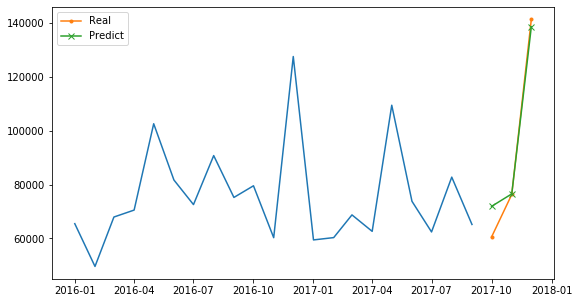

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished


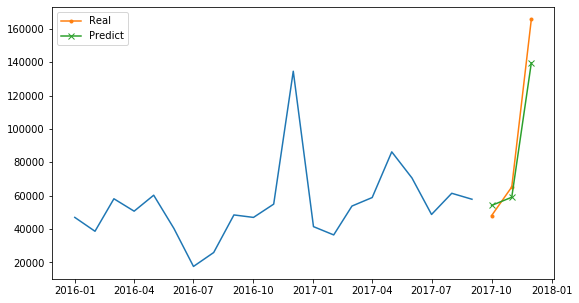

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished


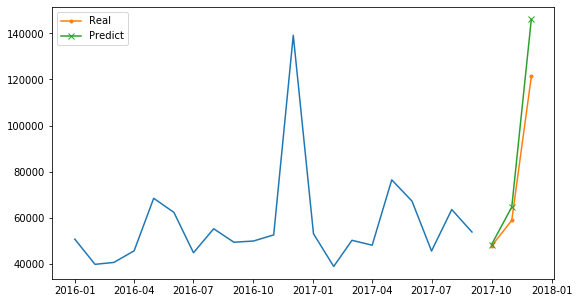

In [207]:
for _ in range(20):
    cod_loja = np.random.choice(X_train["cod_loja"].unique())
    train_index = (X_train["cod_loja"] == cod_loja)
    test_index = (X_test["cod_loja"] == cod_loja)

    _train = train_df[train_index].sort_values("datetime")
    _test = test_df[test_index].sort_values("datetime")

    y_pred = rf.predict(test_df[test_index].drop(str_cols, axis=1, errors="ignore"))

    plt.figure(figsize=(9, 5))
    plt.plot(_train["datetime"], _train["receita"])
    plt.plot(_test["datetime"], _test["receita"], label="Real", marker=".")
    plt.plot(_test["datetime"], y_pred, label="Predict", marker="x")
    plt.legend()
    plt.plot()
    plt.show()